### 필요 라이브러리 import

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, col, avg, count, to_date
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 수집
- 23년 1월 ~ 25년 6월까지의 For-Hire Vehicle.parquet 데이터
- https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [2]:
spark = SparkSession.builder \
    .appName("FHV2506 Analysis") \
    .getOrCreate()

In [3]:
df = spark.read.parquet("./dataset")

## 이동시간 평균(초) 출력

In [4]:
# 연산 진행
tripSeconds = df.agg(
    avg("trip_time").alias("avg_trip_seconds")
)

# 결과 출력
tripSeconds.show()

# 결과 저장
tripSeconds.write \
    .mode("overwrite") \
    .parquet("./output/avgTripSeconds.parquet")

+------------------+
|  avg_trip_seconds|
+------------------+
|1193.6364246858466|
+------------------+



## 이동거리 평균(마일) 출력

In [5]:
# 연산 진행
tripMiles = df.agg(
    avg("trip_miles").alias("avg_trip_miles")
)

# 결과 출력
tripMiles.show()

# 결과 저장
tripSeconds.write \
    .mode("overwrite") \
    .parquet("./output/avgTripMiles.parquet")

+-----------------+
|   avg_trip_miles|
+-----------------+
|5.058332868313209|
+-----------------+



## 시간대 별 택시 이용 시각화

In [6]:
# 1시간 기준으로 시간대 병합
df2 = df.withColumn("pickup_hour", hour(col("pickup_datetime")))

# 시간대별 건수 집계
request_counts = (
    df2
    .groupBy("pickup_hour")
    .agg(count("*").alias("count"))
    .orderBy("pickup_hour")
)

# 결과 출력
request_counts.show()

+-----------+--------+
|pickup_hour|   count|
+-----------+--------+
|          0|21905818|
|          1|15358201|
|          2|11004750|
|          3| 8823361|
|          4| 9062065|
|          5|10556658|
|          6|16288297|
|          7|24348392|
|          8|29643386|
|          9|27614137|
|         10|25438632|
|         11|25029125|
|         12|25634464|
|         13|26581606|
|         14|28736258|
|         15|29478993|
|         16|30358317|
|         17|33551992|
|         18|35100548|
|         19|34045563|
+-----------+--------+
only showing top 20 rows



In [7]:
# 시각화를 위한 DataFrame변환
count_pd = request_counts.toPandas()

In [8]:
# 가장 택시 이용이 많이 이루어진 시간대 peak 정의
peak = count_pd['count'].idxmax()
peak

18

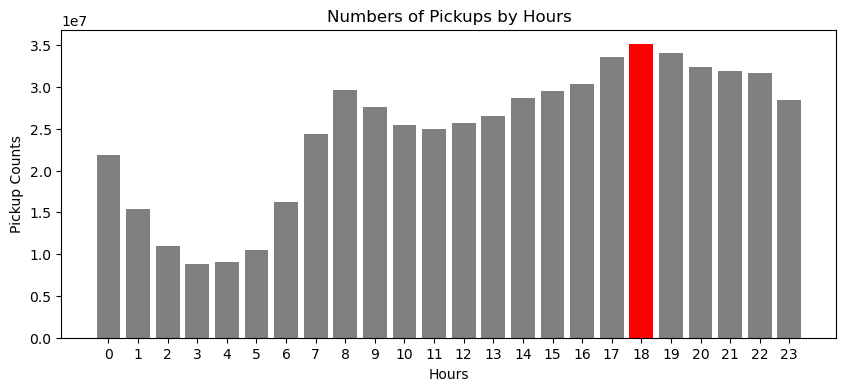

In [9]:
# 시각화 진행
plt.figure(figsize=(10, 4))
colors = ['red' if h == peak else 'gray' for h in count_pd.index]
plt.bar(count_pd['pickup_hour'], count_pd['count'], color = colors)
plt.xlabel('Hours')
plt.ylabel('Pickup Counts')
plt.title('Numbers of Pickups by Hours')
plt.xticks(count_pd.index)
plt.show()

## 날짜 컬럼 기준으로 택시이용자 수, 강수량, 적설량, 평균기온 테이블 제작

### 데이터 수집
- 23년 1월 ~ 25년 6월까지의 Weather.csv데이터
- https://www.ncei.noaa.gov/cdo-web/

In [10]:
weather_df = (
    spark.read
        .option("header", True)
        .option("inferSchema", True)
        .csv("weather.csv")
)

In [11]:
# 날짜, 강수량, 적설량, 평균기온 컬럼만 가진 테이블 제작, 날짜 타입을 Date로 변환
weather_cp = (
    weather_df
      .filter(col("NAME") == "NY CITY CENTRAL PARK, NY US")
      .withColumn(
          "TAVG",
          (
            ( (col("TMAX") + col("TMIN")) / 2 - 32 ) * 5 / 9
          )
      )
      .withColumn("DATE", to_date(col("DATE"), "yyyy-MM-dd"))
      .select("DATE", "PRCP", "SNOW", "TAVG")
)

In [12]:
# 기존 택시 데이터 날짜 타입을 Date로 변환
trip_counts = (
    df
      .withColumn("DATE", to_date(col("pickup_datetime")))
      .groupBy("DATE")
      .agg(count("*").alias("count"))
)

In [13]:
joined = (
    trip_counts
      .join(weather_cp, on="DATE", how="left")
)

### 강수량 기준 택시 이용자 시각화

In [14]:
weather_count = joined.toPandas()

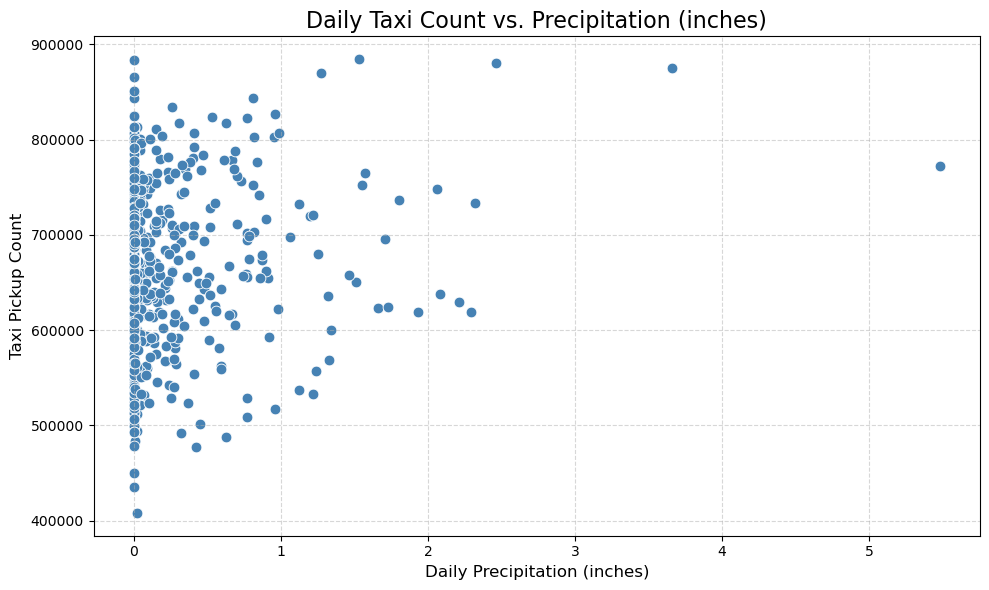

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_count, x=weather_count['PRCP'], y=weather_count['count'], s=60, color='steelblue')

plt.title('Daily Taxi Count vs. Precipitation (inches)', fontsize=16)
plt.xlabel('Daily Precipitation (inches)', fontsize=12)
plt.ylabel('Taxi Pickup Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 적설량 기준 택시 이용자 시각화

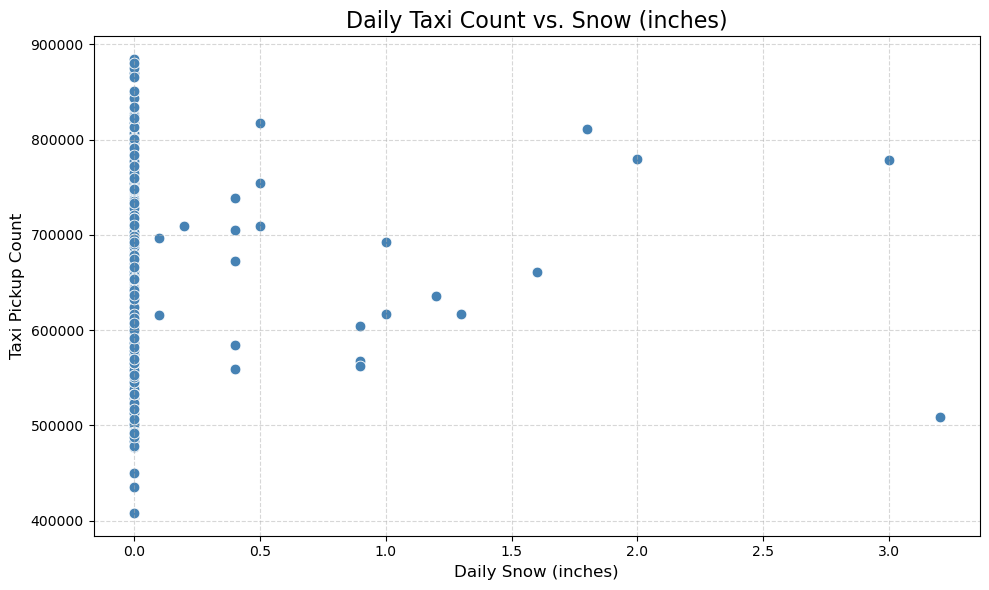

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_count, x=weather_count['SNOW'], y=weather_count['count'], s=60, color='steelblue')

plt.title('Daily Taxi Count vs. Snow (inches)', fontsize=16)
plt.xlabel('Daily Snow (inches)', fontsize=12)
plt.ylabel('Taxi Pickup Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 평균기온 기준 택시 이용자 시각화

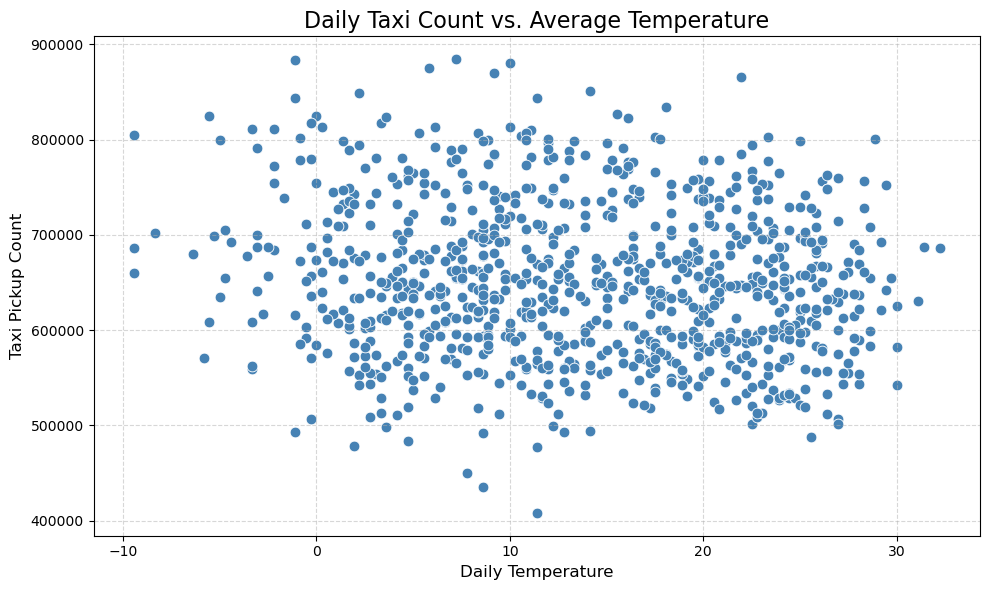

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_count, x=weather_count['TAVG'], y=weather_count['count'], s=60, color='steelblue')

plt.title('Daily Taxi Count vs. Average Temperature', fontsize=16)
plt.xlabel('Daily Temperature', fontsize=12)
plt.ylabel('Taxi Pickup Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 결과 분석

- 편차는 물론 있지만 강수량이 늘어날 수록 사람들은 택시를 더 많이 탄다는 상관관계가 있다는 것을 알 수 있었다.

- 적설량이 늘어날 때도 사람들을 택시를 더 많이 탄다는 상관관계가 있다고 볼 수 있을 것이다. 데이터가 적기 때문에 확실하게 말은 하지 못한다. 주요한 특징은 3인치가 넘어갈 때 택시 이용자 수가 급감한다는 것인데 아마 폭설이라고 판단하여 집 밖에 나가지 못하게 해서 그럴 것이라고 판단하였다.

- 평균기온과 택시 이용자 수의 상관관계는 없다고 보는 것이 맞는 것 같다. 여러 곳에 고루 분포되어 있는 산점도를 볼 수 있다.

- 결과적으로 기온과 관계 없이 비나 눈이 많이 오는 등 기상조건이 악화될 수록 사람들은 택시를 더 많이 탄다는 관계를 알 수 있었다.